## グローバーアルゴリズムの実装（$N=2^6$の場合）
ではここから、実際にグローバーアルゴリズムを実装してデータベースの検索問題に取り掛かってみましょう。

ここで考える問題は、$N=2^6$個の要素を持つリスト（$=[0,1,2,\cdots,63]$）から、一つの答え"45"を見つけるグローバーアルゴリズムの実装です（もちろんこの数はなんでも良いので、後で自由に変更して遊んでみてください）。つまり6量子ビットの量子回路を使って、$|45\rangle=|101101\rangle$を探す問題です。

### 最初に以下の２つのセルを実行しておいてください。


In [ ]:
import sys
import shutil
import tarfile
from google.colab import drive
drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.10/site-packages')

!git clone -b branch-2024 https://github.com/UTokyo-ICEPP/qc-workbook-lecturenotes
!cp -r qc-workbook-lecturenotes/qc_workbook /root/.local/lib/python3.10/site-packages/

In [1]:
# Tested with python 3.10.14, qiskit 1.0.2, numpy 1.26.4, scipy 1.13.0
import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Sampler

In [2]:
# IBMidの登録が済んでいて、Provider情報を受け取っている人は
# 　instance='ibm-q-utokyo/internal/__your_project_here__'
# を指定して、セットアップ時に作ったqiskit-ibm.jsonファイルを上書き保存する
QiskitRuntimeService.save_account(channel='ibm_quantum', token='__your_API_token_here__',
                                  instance='ibm-q-utokyo/internal/__your_project_here__',
                                  filename='/content/gdrive/MyDrive/qiskit-ibm.json', overwrite=True)

NameError: name 'QiskitRuntimeService' is not defined

In [2]:
from qc_workbook.grover import make_grover_circuit

n_qubits = 6

# 量子コンピュータで実行する場合
runtime_config_path = '/content/gdrive/MyDrive/qiskit-ibm.json'
service = QiskitRuntimeService(filename=runtime_config_path)

# 最も空いているバックエンドを見つけて、そのバックエンドに対して回路をトランスパイル
backend = service.least_busy(min_num_qubits=n_qubits, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

grover_circuit = make_grover_circuit(n_qubits)
grover_circuit_transpiled = transpile(grover_circuit, backend=backend, optimization_level=3)
job_ibmq = backend.run(grover_circuit_transpiled, shots=2048)
print(f'Submitted job {job_ibmq.job_id()}')


OSError: [Errno 30] Read-only file system: '/content'

### グローバー探索の量子回路を実装する

6量子ビットの回路`grover_circuit`を準備します。

グローバー反復を一回実行する量子回路は以下のような構成になりますが、赤枠で囲んだ部分（オラクルとDiffuserの中の$2|0\rangle\langle 0|-I$の部分）を実装する量子回路を書いてください。

一様な重ね合わせ状態$|s\rangle$を生成した後に、オラクルを実装します。

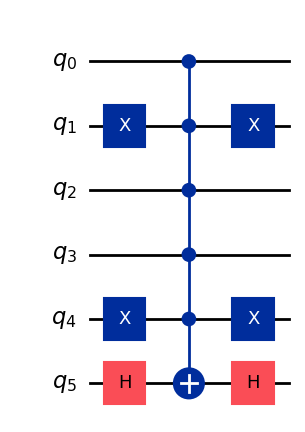

In [16]:
Nsol = 45
n_qubits = 6

grover_circuit = QuantumCircuit(n_qubits)

grover_circuit.h(range(n_qubits))
grover_circuit.barrier()

# オラクルを作成して、回路に実装
oracle = QuantumCircuit(n_qubits)

##################
### EDIT BELOW ###
##################

#oracle.?
oracle.x(1)
oracle.x(4)
oracle.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle.x(1)
oracle.x(4)

##################
### EDIT ABOVE ###
##################

oracle_gate = oracle.to_gate()
oracle_gate.name = "U_w"
oracle.draw('mpl')

次に、Diffuser用の回路を実装します。

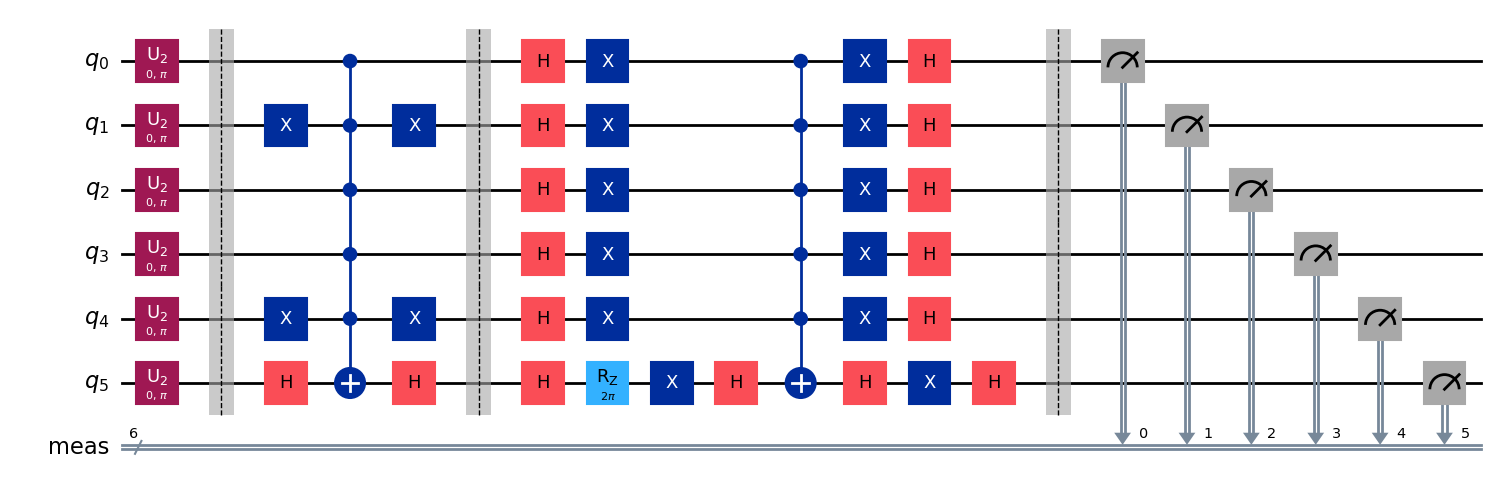

In [17]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))

    ##################
    ### EDIT BELOW ###
    ##################

    #qc.?
    qc.rz(2*np.pi, n-1)
    qc.x(list(range(n)))

    # multi-controlled Zゲート
    qc.mcp(np.pi, list(range(n-1)), n-1)

    qc.x(list(range(n)))
    ##################
    ### EDIT ABOVE ###
    ##################

    qc.h(range(n))

    #print(qc)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

grover_circuit.append(oracle_gate, list(range(n_qubits)))
grover_circuit.barrier()
grover_circuit.append(diffuser(n_qubits), list(range(n_qubits)))
grover_circuit.measure_all()
grover_circuit.decompose().draw('mpl')

### シミュレータでの実験

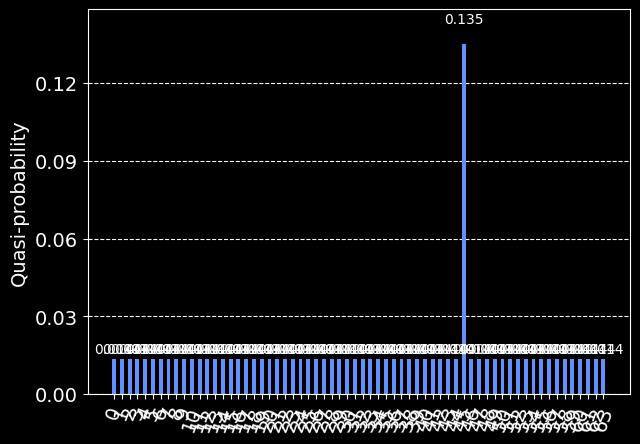

In [11]:
# Instantiate new AerSimulator and Sampler objects
simulator = AerSimulator()
sampler = Sampler()

# Now run the job and examine the results
grover_circuit = transpile(grover_circuit, backend=simulator)
sampler_job = sampler.run(grover_circuit, shots=10000)
result = sampler_job.result()

from qiskit.visualization import plot_distribution
#plt.style.use('dark_background')
plot_distribution(result.quasi_dists[0])

### 振幅増幅を確認する

では次に、グローバーのアルゴリズムを繰り返し使うことで、振幅が増幅していく様子をシミュレータを使って見てみましょう。

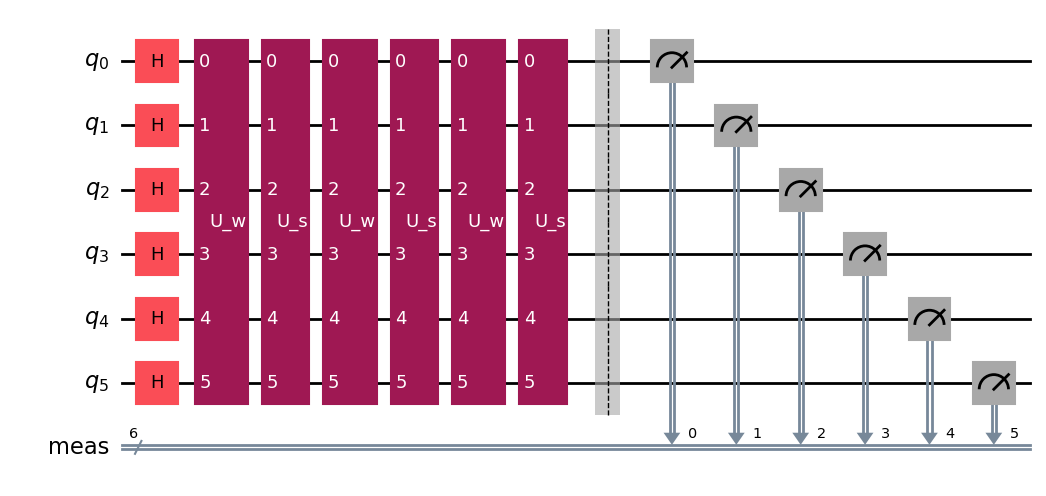

In [12]:
# 繰り返しの回数
Niter = 3

grover_circuit_iterN = QuantumCircuit(n_qubits)
grover_circuit_iterN.h(range(n_qubits))
grover_circuit_iterN.barrier()
for I in range(Niter):
    grover_circuit_iterN.append(oracle_gate, list(range(n_qubits)))
    grover_circuit_iterN.barrier()
    grover_circuit_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
    grover_circuit_iterN.barrier()
grover_circuit_iterN.measure_all()
grover_circuit_iterN.decompose().draw('mpl')

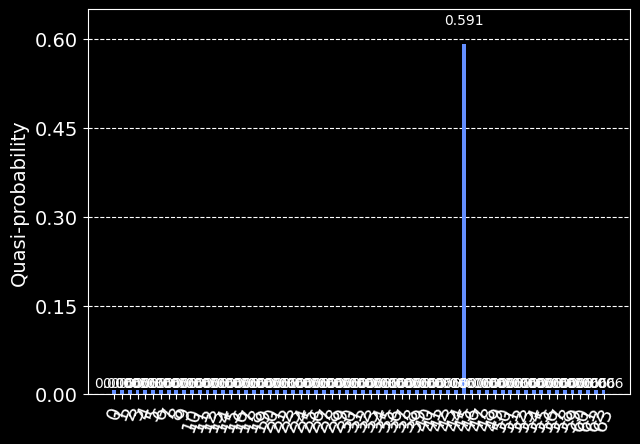

In [14]:
grover_circuit_iterN = transpile(grover_circuit_iterN, backend=simulator)
sampler_job = sampler.run(grover_circuit_iterN, shots=10000)
result = sampler_job.result()
plot_distribution(result.quasi_dists[0])

では次に、実装した回路を繰り返し実行して、求める解を観測した回数と反復した回数との相関関係を図にしてみます。

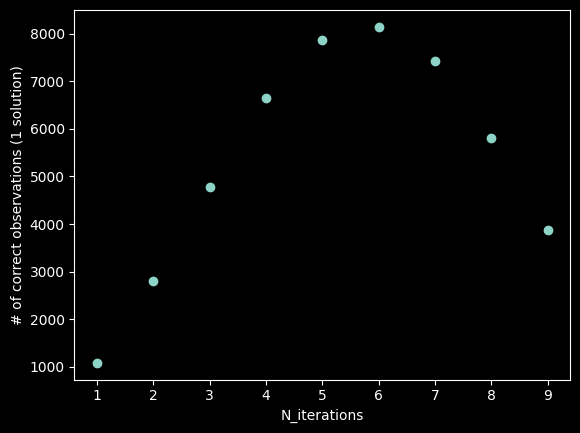

In [15]:
simulator = AerSimulator()
sampler = Sampler()

x = []
y = []

shots = 10000

# 例えば10回繰り返す
for Niter in range(1,10):
    grover_circuit_iterN = QuantumCircuit(n_qubits)
    grover_circuit_iterN.h(range(n_qubits))
    for I in range(Niter):
        grover_circuit_iterN.append(oracle_gate, list(range(n_qubits)))
        grover_circuit_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
    grover_circuit_iterN.measure_all()
    #print(grover_circuit_iterN)

    grover_circuit_iterN = transpile(grover_circuit_iterN, backend=simulator)
    sampler_job_iterN = sampler.run(grover_circuit_iterN, shots=shots)
    results_sim_iterN = sampler_job_iterN.result()
    
    x.append(Niter)
    y.append(results_sim_iterN.quasi_dists[0][Nsol]*shots)

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (1 solution)')
plt.show()

この図から、グローバー反復を5~6回程度繰り返すことで、正しい答えを最も高い確率で測定できることが分かりますね。計算で求めた検索に必要な反復回数と一致しているかどうか、確認してみてください。

問題：解が一つの場合で、探索リストのサイズを$N=2^4$から$N=2^{10}$まで変えた時に、測定で求めた最適な反復回数が$N$とどういう関係になっているのか調べてください。

### 複数解の探索の場合

では次に、複数の解を探索する問題に進んでみましょう。2つの整数$x_1$と$x_2$を見つける問題へ量子回路を拡張して、求める解を観測した回数と反復した回数との相関関係を図にしてみます。

例えば、$x_1=45$と$x_2=26$の場合は

In [ ]:
N1 = 45
N2 = 26

# 45
oracle_2sol_1 = QuantumCircuit(n_qubits)
oracle_2sol_1.x(1)
oracle_2sol_1.x(4)
oracle_2sol_1.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle_2sol_1.x(1)
oracle_2sol_1.x(4)

# 26
oracle_2sol_2 = QuantumCircuit(n_qubits)
oracle_2sol_2.x(0)
oracle_2sol_2.x(2)
oracle_2sol_2.x(5)
oracle_2sol_2.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle_2sol_2.x(0)
oracle_2sol_2.x(2)
oracle_2sol_2.x(5)

oracle_2sol_gate = QuantumCircuit(n_qubits)
oracle_2sol_gate.append(oracle_2sol_1.to_gate(), list(range(n_qubits)))
oracle_2sol_gate.barrier()
oracle_2sol_gate.append(oracle_2sol_2.to_gate(), list(range(n_qubits)))
oracle_2sol_gate.barrier()
oracle_2sol_gate.name = "U_w(2sol)"
oracle_2sol_gate.decompose().draw('mpl')

In [ ]:
x = []
y = []
for Niter in range(1,11):
    grover_circuit_2sol_iterN = QuantumCircuit(n_qubits)
    grover_circuit_2sol_iterN.h(range(n_qubits))
    for I in range(Niter):
        grover_circuit_2sol_iterN.append(oracle_2sol_gate, list(range(n_qubits)))
        grover_circuit_2sol_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
    grover_circuit_2sol_iterN.measure_all()
    #print('-----  Niter =',Niter,' -----------')
    #print(grover_circuit_2sol_iterN)

    grover_circuit_2sol_iterN = transpile(grover_circuit_2sol_iterN, backend=simulator)
    sampler_job_2sol_iterN = sampler.run(grover_circuit_2sol_iterN, shots=shots)
    results_sim_2sol_iterN = sampler_job_2sol_iterN.result()

    x.append(Niter)
    y.append((results_sim_2sol_iterN.quasi_dists[0][N1]+results_sim_2sol_iterN.quasi_dists[0][N2])*shots)

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (2 solutions)')
plt.show()

### 量子コンピュータでの実験

グローバー反復を一回実行する回路は最初に実機で実行していたので、その結果を取ってきてシミュレーションの結果と比較します。

In [ ]:
# 最初に実行した結果を取ってくる
print('Simulator')
show_distribution(answer_sim)

results_ibmq = job_ibmq.result()
answer_ibmq = results_ibmq.get_counts(grover_circuit_transpiled)
print(f"IBM backend: {backend.name}, Job ID: {job_ibmq.job_id()}")
show_distribution(answer_ibmq)

**上の問題の回答**

オラクルの中身

In [ ]:
oracle.x(1)
oracle.x(4)
oracle.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle.x(1)
oracle.x(4)

Diffuserの中身

In [ ]:
    qc.rz(2*np.pi, n_qubits-1)
    qc.x(list(range(n_qubits)))

    # multi-controlled Zゲート
    qc.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)

    qc.x(list(range(n)))